In this notebook we discuss the approach to a rework in the special infected aggro system, to make them chase higher level players instead of swarming random players that could be very low level. Players of low level that die quickly will not remain in the server. This is also a way to reduce lower level player's stress and increase the challenge for higher level players.

### Desirability

Let $D(p)$ be the function that describes the desire of a special infecred (**S.I**) to attack the player $p$. This desire is driven by how **far** the player is and how **juicy or strong** he is too. This kind of emulates the behaviour of hunting in real life, where animals will prefer a better prey that is bigger and has more meat, but also taking into account the effort it takes to get to it (which in our case, is just the distance).

With all this, we can define the desire function as:

$ D(p) = 1 - $ How distant the target is $ - $ its lack of power

This means that every player is completely desirable at first (with a value of 1), and loses desirabiliy when we discount how far it is, or how weak it is. A player with desirability of 0 is completely undesirable. It is technically impossible to have desirabiliy 0, but even so, the special infected will attack a lonely player regardless of its desirability.

To find the desire, we must calculate the penalties of distance and power.

### Distance

Two targets that are very close to the SI are equally highly desirable in therms of distance. Also, two targets that are very far from me are also equally not too desirable. The biggest difference in desirabiliy should happen between targets that are close and not so close to me.

A little bit more graphic:


<img src="distance-scenario.jpg" width="350">

The function, considering a maximum viable distance of 2000 units should be as follows:

<img src="distance-desirability.jpg" width="200">

The function simulates the desirability penalty. The more distance, the higher the penalty and the less desirable the target, but it includes a sigmoid curve to only make impotante distance differences relevant.

A sigmoid curve follows the formula:

$ \frac{1}{1 + e^{-x}} $

with a curve like this:

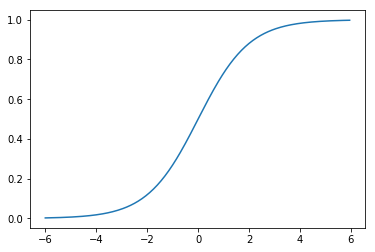

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(-6, 6, 0.05)
plt.plot(x, sigmoid(x))
plt.show()


Then, our desirability formula for the distance is:

$ \Large{D_p(p_{distance}) = \frac{1}{1 + e^ {-\left(6 \cdot \frac{(distance - 1000)}{1000}\right)}}} $

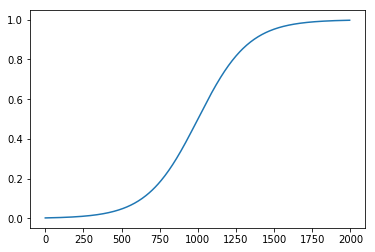

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def distance_penalty(x):
    return 1 / (1 + np.exp(-6*(x - 1000)/1000))

x = np.arange(0, 2000, 5)
plt.plot(x, distance_penalty(x))
plt.show()

### Power
The desirability in therms of player power behaves differently. The higher the level of the player, the more desirable it is. However, the comparison between levels is not linear.

The penalty in this case starts at 1, since, somebody with level 0 is completely undesirable as the infecred won't benefit at all from him. The ideal formula should be something similar to this:

<img src="power-desirability.jpg" width="200">

There should be a drastic spike in desirability between players of level 200 and 201. This is simply because players of level 201 have access to a high amount of buffs and upgrades that greatly increase their power.

With this, we obtain the following formula for the power penalty:



\begin{equation}
\large{
S_p(p_{level}) = 
     \begin{cases}
       1 - \frac{1}{1 + e^ {-\left(6 \cdot \frac{(distance - 200)}{200}\right)}} &\quad\text{if 0} \le \text{level} \le 200 \\
       \left(1 - \frac{1}{1 + e^ {-\left(6 \cdot \frac{(distance - 200)}{50}\right)}}\right) \cdot 0.6 &\quad\text{if 201} \le \text{level} \le 250 \\
     \end{cases}
}
\end{equation}


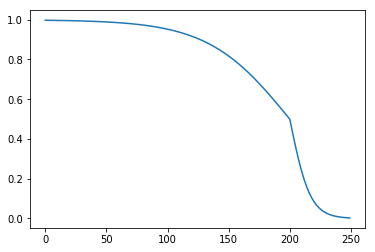

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def power_penalty(x):
    
    if (x <= 200):
        return 1 - (1 / (1 + np.exp(-6*(x - 200)/200)))
    
    return (1 - (1 / (1 + np.exp(-6*(x - 200)/50))))

x = np.arange(0, 250, 1)

res = list(map(lambda elem: power_penalty(elem), x))
plt.plot(x, res)
plt.show()

Finally, our desirabiliy equation is reduced to:


$ D(p) = 1 - \alpha \cdot D_p(p_{distance}) - (1 - \alpha) \cdot S_p(p_{level})$

where $\alpha$ tells us the impotance of the distance in the desirabiliy outcome. Since power should be the most important deciding factor, $\alpha$ should have values in the interval $[0.1, 0.2]$




In [4]:
alpha = 0.2
def desirability(distance, level):
    return 1 - alpha*distance_penalty(distance) - (1 - alpha)*power_penalty(level)

After we obtain our desirability value for all players, we obtain a random number from a normal distribution with norm 1 and variance that gives us numbers to up to 1. The distribution does not give a range between 0 and 1, but we can truncate it.

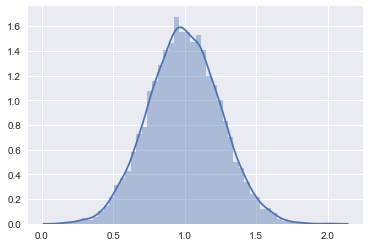

In [5]:
import seaborn as sns
sns.set(color_codes=True)

mean = 1
variance = 0.25
test = np.random.normal(mean, variance, size=10000)
sns.distplot(test);

plt.show()

This kind of emulates a situation where a special infected would lower its standards

## Experiments

##### Logical cases

In [6]:
print("Low level really close: %f %f %f" % (power_penalty(35), distance_penalty(35), desirability(0, 35)))
print("Low level really far: %f %f %f" % (power_penalty(35), distance_penalty(2000), desirability(2000, 35)))
print("High level really close: %f %f %f" % (power_penalty(250), distance_penalty(0), desirability(0, 250)))
print("High level really far: %f %f %f" % (power_penalty(250), distance_penalty(2000), desirability(2000, 250)))

Low level really close: 0.992966 0.003049 0.205132
Low level really far: 0.992966 0.997527 0.006121
High level really close: 0.002473 0.002473 0.997527
High level really far: 0.002473 0.997527 0.798516


##### Behavior given a set of players

In [7]:
#(level, distance)
from random import randint
from operator import itemgetter

# Generate random players
players = []
for p in range(0, 75):
    level = randint(0, 250)
    distance = randint(0, 2000)
    name = "Player %d" % p
    players.append({
        "level": randint(0, 250),
        "distance": randint(0, 1000),
        "name": "Player %d" % p,
        "desirability": desirability(distance, level)
    })


In [8]:
def select_player_to_eath(players):
    # Choose!

    chosen = np.abs(np.random.normal(1, 0.25))
    chosen = 1 if chosen > 1 else chosen

    # Sort and get the player with closest desirability

    chosen_player = None

    print('Random desirability: %f' % chosen)

    for p in players:
        if (chosen_player == None
        or np.abs(chosen - chosen_player["desirability"]) > np.abs(chosen - p["desirability"]) ):
            chosen_player = p

    print('Chosen player "%s" (Lv. %d) at %.2f units (desirability %f)\n' % (chosen_player["name"], chosen_player["level"], chosen_player["distance"], chosen_player["desirability"]))

In [9]:
for x in range(0, 30):
    select_player_to_eath(players)

Random desirability: 1.000000
Chosen player "Player 9" (Lv. 125) at 870.00 units (desirability 0.995522)

Random desirability: 1.000000
Chosen player "Player 9" (Lv. 125) at 870.00 units (desirability 0.995522)

Random desirability: 1.000000
Chosen player "Player 9" (Lv. 125) at 870.00 units (desirability 0.995522)

Random desirability: 1.000000
Chosen player "Player 9" (Lv. 125) at 870.00 units (desirability 0.995522)

Random desirability: 0.902915
Chosen player "Player 0" (Lv. 174) at 865.00 units (desirability 0.894416)

Random desirability: 0.850318
Chosen player "Player 70" (Lv. 32) at 350.00 units (desirability 0.850292)

Random desirability: 1.000000
Chosen player "Player 9" (Lv. 125) at 870.00 units (desirability 0.995522)

Random desirability: 0.863869
Chosen player "Player 70" (Lv. 32) at 350.00 units (desirability 0.850292)

Random desirability: 0.990181
Chosen player "Player 7" (Lv. 58) at 612.00 units (desirability 0.987539)

Random desirability: 1.000000
Chosen player "Pl